In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, Markdown, Latex

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#sim_name = 'TNG100-1'
sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

## Load features

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG50-4.yaml
../configs/geo_TNG50-4.yaml
../configs/scalar_TNG50-4.yaml


In [4]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [5]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [6]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [7]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [8]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [9]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


## Gather properties

In [10]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

## Split train-val-test

In [11]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

# Mutual info

In [87]:
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.utils.analytic_MI import calculate_MI_D1_analytical

In [88]:
import scipy.stats

In [89]:
y_label_name = 'm_stellar'
y = utils.get_y_vals(y_label_name, sim_reader)
y_train = y[idx_train]
print(y_train.shape)

(340,)


In [90]:
s_train = scalar_featurizer.scalar_features[idx_train]
s_arr_train = scalar_featurizer.scalar_feature_arr[idx_train]

In [91]:
s_train.shape

(340, 567)

In [92]:
MI_means = []
MI_stds = []
spearmans = []

In [93]:
for i in range(s_train.shape[1]):
    print(i, scalar_name(s_arr_train[0,i], scalar_featurizer.geo_feature_arr))
    s_train_i = s_train[:,i]
    X = np.vstack((s_train_i, y_train)).T
    
    mi_estimator = EstimateMI()
    MI_mean, MI_std = mi_estimator.fit(X)
    MI_means.append(MI_mean)
    MI_stds.append(MI_std)
    #print(MI_mean, MI_std)
    
    res = scipy.stats.spearmanr(s_train_i, y_train)
    spearmans.append(res[0])

0 $m_0$


100%|██████████| 50/50 [00:03<00:00, 15.79it/s]


1 $m_1$


100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


2 $m_2$


100%|██████████| 50/50 [00:04<00:00, 10.05it/s]


3 $\lambda_3\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 16.66it/s]


4 $\lambda_1\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 16.53it/s]


5 $\lambda_2\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:04<00:00, 12.09it/s]


6 $\lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  9.77it/s]


7 $\lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 17.16it/s]


8 $\lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 16.97it/s]


9 $\lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.90it/s]


10 $\lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 14.35it/s]


11 $\lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.07it/s]


12 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.66it/s]


13 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.90it/s]


14 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:04<00:00, 12.11it/s]


15 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:03<00:00, 16.50it/s]


16 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:03<00:00, 12.98it/s]


17 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.56it/s]


18 $\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.96it/s]


19 $\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:02<00:00, 18.61it/s]


20 $\lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 12.42it/s]


21 $\lambda_2\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 16.92it/s]


22 $\lambda_3\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


23 $\lambda_1\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:05<00:00,  9.90it/s]


24 $\lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.91it/s]


25 $\lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


26 $\lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.38it/s]


27 $\lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:08<00:00,  5.56it/s]


28 $\lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.96it/s]


29 $\lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.02it/s]


30 $m_0 \, m_0$


100%|██████████| 50/50 [00:03<00:00, 15.93it/s]


31 $m_0 \, m_1$


100%|██████████| 50/50 [00:04<00:00, 11.74it/s]


32 $m_0 \, m_2$


100%|██████████| 50/50 [00:05<00:00,  9.79it/s]


33 $m_1 \, m_1$


100%|██████████| 50/50 [00:03<00:00, 13.14it/s]


34 $m_1 \, m_2$


100%|██████████| 50/50 [00:06<00:00,  8.21it/s]


35 $m_2 \, m_2$


100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


36 $m_0 \, \lambda_1\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:05<00:00,  9.14it/s]


37 $m_0 \, \lambda_2\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 17.33it/s]


38 $m_0 \, \lambda_3\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 17.20it/s]


39 $[v_0]_{j} \, [v_0]_{j}$


100%|██████████| 50/50 [00:03<00:00, 14.69it/s]


40 $\lambda_1\left(C^{vv}_0\right) \, m_1$


100%|██████████| 50/50 [00:03<00:00, 14.98it/s]


41 $\lambda_3\left(C^{vv}_0\right) \, m_1$


100%|██████████| 50/50 [00:03<00:00, 16.60it/s]


42 $m_0 \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.79it/s]


43 $m_0 \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 17.77it/s]


44 $\lambda_2\left(C^{vv}_0\right) \, m_1$


100%|██████████| 50/50 [00:02<00:00, 17.55it/s]


45 $[v_0]_{j} \, [v_1]_{j}$


100%|██████████| 50/50 [00:04<00:00, 10.65it/s]


46 $m_0 \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 14.13it/s]


47 $[v_0]_{j} \, [v_2]_{j}$


100%|██████████| 50/50 [00:03<00:00, 12.53it/s]


48 $m_0 \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.79it/s]


49 $\lambda_3\left(C^{vv}_0\right) \, m_2$


100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


50 $m_0 \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.12it/s]


51 $\lambda_1\left(C^{vv}_0\right) \, m_2$


100%|██████████| 50/50 [00:05<00:00,  8.79it/s]


52 $\lambda_2\left(C^{vv}_0\right) \, m_2$


100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


53 $m_0 \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.02it/s]


54 $[v_1]_{j} \, [v_1]_{j}$


100%|██████████| 50/50 [00:05<00:00,  9.13it/s]


55 $m_1 \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 12.38it/s]


56 $m_1 \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:06<00:00,  7.48it/s]


57 $m_1 \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.20it/s]


58 $[v_1]_{j} \, [v_2]_{j}$


100%|██████████| 50/50 [00:05<00:00,  9.58it/s]


59 $m_1 \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


60 $m_1 \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 14.43it/s]


61 $m_1 \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.58it/s]


62 $\lambda_3\left(C^{vv}_1\right) \, m_2$


100%|██████████| 50/50 [00:05<00:00,  9.50it/s]


63 $\lambda_2\left(C^{vv}_1\right) \, m_2$


100%|██████████| 50/50 [00:04<00:00, 10.92it/s]


64 $\lambda_1\left(C^{vv}_1\right) \, m_2$


100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


65 $[v_2]_{j} \, [v_2]_{j}$


100%|██████████| 50/50 [00:05<00:00,  9.27it/s]


66 $m_2 \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


67 $m_2 \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.80it/s]


68 $m_2 \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.77it/s]


69 $\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:04<00:00, 12.31it/s]


70 $\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:05<00:00,  9.99it/s]


71 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 17.52it/s]


72 $\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 15.92it/s]


73 $\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 12.69it/s]


74 $\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_0\right)$


100%|██████████| 50/50 [00:05<00:00,  9.28it/s]


75 $[C^{vv}_0]_{jk} \, [C^{vv}_0]_{jk}$


100%|██████████| 50/50 [00:02<00:00, 17.11it/s]


76 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 18.66it/s]


77 $\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.30it/s]


78 $\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.92it/s]


79 $\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.99it/s]


80 $\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 17.95it/s]


81 $\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 12.19it/s]


82 $[C^{vv}_0]_{jk} \, [C^{vv}_1]_{jk}$


100%|██████████| 50/50 [00:03<00:00, 15.63it/s]


83 $\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.72it/s]


84 $\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 14.40it/s]


85 $\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 18.06it/s]


86 $\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.66it/s]


87 $\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 12.25it/s]


88 $\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.90it/s]


89 $\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.51it/s]


90 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.36it/s]


91 $\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.53it/s]


92 $\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.20it/s]


93 $[C^{vv}_0]_{jk} \, [C^{vv}_2]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  8.46it/s]


94 $\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.96it/s]


95 $\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.79it/s]


96 $\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.23it/s]


97 $[C^{vv}_1]_{jk} \, [C^{vv}_1]_{jk}$


100%|██████████| 50/50 [00:02<00:00, 18.22it/s]


98 $\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 18.46it/s]


99 $\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.75it/s]


100 $\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


101 $\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.19it/s]


102 $\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 18.06it/s]


103 $\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 15.38it/s]


104 $\lambda_2\left(C^{vv}_1\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.85it/s]


105 $\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.84it/s]


106 $\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.52it/s]


107 $\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.87it/s]


108 $\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.44it/s]


109 $\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.53it/s]


110 $\lambda_1\left(C^{vv}_1\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.27it/s]


111 $\lambda_1\left(C^{vv}_1\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  8.27it/s]


112 $[C^{vv}_1]_{jk} \, [C^{vv}_2]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 11.96it/s]


113 $\lambda_2\left(C^{vv}_2\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.72it/s]


114 $\lambda_3\left(C^{vv}_2\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


115 $\lambda_3\left(C^{vv}_2\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.10it/s]


116 $\lambda_3\left(C^{vv}_2\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.71it/s]


117 $\lambda_1\left(C^{vv}_2\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 12.67it/s]


118 $[C^{vv}_2]_{jk} \, [C^{vv}_2]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 12.03it/s]


119 $\lambda_2\left(C^{vv}_2\right) \, \lambda_1\left(C^{vv}_2\right)$


/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/gmm_mi/gmm.py:235: ConvergenceWarning: A fit did not converge. Try different init parameters, or increase max_iter, decrease threshold_fit or check for degenerate data.
  warnings.warn(
100%|██████████| 50/50 [00:04<00:00, 11.02it/s]


120 $m_0 \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.86it/s]


121 $[v_0]_{j} \, [x_0]_{j}$


100%|██████████| 50/50 [00:04<00:00, 10.07it/s]


122 $m_0 \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.62it/s]


123 $m_0 \, \lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.87it/s]


124 $m_0 \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.89it/s]


125 $m_0 \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:02<00:00, 17.01it/s]


126 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_1$


100%|██████████| 50/50 [00:03<00:00, 14.66it/s]


127 $m_0 \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:03<00:00, 12.85it/s]


128 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_1$


100%|██████████| 50/50 [00:05<00:00,  9.34it/s]


129 $[x_0]_{j} \, [v_1]_{j}$


100%|██████████| 50/50 [00:04<00:00, 11.79it/s]


130 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_1$


100%|██████████| 50/50 [00:03<00:00, 13.54it/s]


131 $[v_0]_{j} \, [x_1]_{j}$


100%|██████████| 50/50 [00:04<00:00, 12.02it/s]


132 $[v_0]_{j} \, [x_2]_{j}$


100%|██████████| 50/50 [00:03<00:00, 15.01it/s]


133 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_2$


100%|██████████| 50/50 [00:06<00:00,  7.93it/s]


134 $m_0 \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.71it/s]


135 $m_0 \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.31it/s]


136 $m_0 \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 12.00it/s]


137 $[x_0]_{j} \, [v_2]_{j}$


100%|██████████| 50/50 [00:02<00:00, 18.33it/s]


138 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_2$


100%|██████████| 50/50 [00:03<00:00, 13.46it/s]


139 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, m_2$


100%|██████████| 50/50 [00:03<00:00, 12.71it/s]


140 $m_1 \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


141 $[v_1]_{j} \, [x_1]_{j}$


100%|██████████| 50/50 [00:04<00:00, 11.09it/s]


142 $m_1 \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.76it/s]


143 $m_1 \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.77it/s]


144 $[v_1]_{j} \, [x_2]_{j}$


100%|██████████| 50/50 [00:04<00:00, 12.02it/s]


145 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, m_2$


100%|██████████| 50/50 [00:04<00:00, 11.39it/s]


146 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, m_2$


100%|██████████| 50/50 [00:04<00:00, 10.62it/s]


147 $[x_1]_{j} \, [v_2]_{j}$


100%|██████████| 50/50 [00:05<00:00,  9.37it/s]


148 $m_1 \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.72it/s]


149 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, m_2$


100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


150 $m_1 \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.52it/s]


151 $m_1 \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:02<00:00, 18.73it/s]


152 $m_2 \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.62it/s]


153 $[v_2]_{j} \, [x_2]_{j}$


100%|██████████| 50/50 [00:05<00:00,  9.11it/s]


154 $m_2 \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.41it/s]


155 $m_2 \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.76it/s]


156 $[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk}$


100%|██████████| 50/50 [00:03<00:00, 14.01it/s]


157 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:03<00:00, 12.57it/s]


158 $\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.33it/s]


159 $\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.99it/s]


160 $\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.77it/s]


161 $\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.23it/s]


162 $\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:02<00:00, 17.70it/s]


163 $\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.67it/s]


164 $\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.10it/s]


165 $\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.70it/s]


166 $\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.91it/s]


167 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


168 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


169 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.61it/s]


170 $\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:02<00:00, 17.33it/s]


171 $\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.99it/s]


172 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.22it/s]


173 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.90it/s]


174 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  9.52it/s]


175 $[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.38it/s]


176 $[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [C^{vv}_1]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 11.52it/s]


177 $\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.94it/s]


178 $\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:03<00:00, 13.74it/s]


179 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.28it/s]


180 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 12.63it/s]


181 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 12.35it/s]


182 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.75it/s]


183 $\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]


184 $\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:02<00:00, 17.00it/s]


185 $\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:02<00:00, 17.36it/s]


186 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 13.20it/s]


187 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:02<00:00, 18.44it/s]


188 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.24it/s]


189 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 12.96it/s]


190 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 14.64it/s]


191 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 12.90it/s]


192 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 16.39it/s]


193 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.48it/s]


194 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.70it/s]


195 $\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.74it/s]


196 $\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.53it/s]


197 $\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.98it/s]


198 $\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.52it/s]


199 $\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.97it/s]


200 $\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.79it/s]


201 $[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [C^{vv}_2]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 11.69it/s]


202 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.85it/s]


203 $\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.70it/s]


204 $\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:06<00:00,  7.39it/s]


205 $[C^{vv}_0]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.95it/s]


206 $\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.20it/s]


207 $\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.45it/s]


208 $\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.22it/s]


209 $\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.17it/s]


210 $\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


211 $\lambda_1\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.70it/s]


212 $\lambda_1\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.74it/s]


213 $[C^{vv}_1]_{jk} \, [\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk}$


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


214 $\lambda_2\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.72it/s]


215 $\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:02<00:00, 17.47it/s]


216 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 12.77it/s]


217 $[\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk} \, [C^{vv}_2]_{jk}$


100%|██████████| 50/50 [00:06<00:00,  7.28it/s]


218 $[C^{vv}_1]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  9.31it/s]


219 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.43it/s]


220 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:02<00:00, 17.29it/s]


221 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


222 $\lambda_2\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:06<00:00,  7.51it/s]


223 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.93it/s]


224 $\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.53it/s]


225 $\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.38it/s]


226 $\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 12.02it/s]


227 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.43it/s]


228 $\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.50it/s]


229 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.39it/s]


230 $\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.62it/s]


231 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.82it/s]


232 $\lambda_1\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.69it/s]


233 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 14.92it/s]


234 $\lambda_1\left(C^{vv}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.76it/s]


235 $\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.23it/s]


236 $\lambda_1\left(C^{vv}_2\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 12.72it/s]


237 $\lambda_1\left(C^{vv}_2\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.82it/s]


238 $\lambda_1\left(C^{vv}_2\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.70it/s]


239 $\lambda_2\left(C^{vv}_2\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.68it/s]


240 $\lambda_2\left(C^{vv}_2\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 12.53it/s]


241 $\lambda_2\left(C^{vv}_2\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.77it/s]


242 $\lambda_3\left(C^{vv}_2\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:06<00:00,  8.24it/s]


243 $\lambda_3\left(C^{vv}_2\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.98it/s]


244 $[C^{vv}_2]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 11.03it/s]


245 $\lambda_3\left(C^{vv}_2\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.21it/s]


246 $m_0 \, \lambda_3\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 17.06it/s]


247 $m_0 \, \lambda_2\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 16.81it/s]


248 $m_0 \, \lambda_1\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 17.01it/s]


249 $[x_0]_{j} \, [x_0]_{j}$


100%|██████████| 50/50 [00:05<00:00,  8.39it/s]


250 $\lambda_1\left(C^{xx}_0\right) \, m_1$


100%|██████████| 50/50 [00:03<00:00, 14.57it/s]


251 $\lambda_3\left(C^{xx}_0\right) \, m_1$


100%|██████████| 50/50 [00:04<00:00, 10.52it/s]


252 $[x_0]_{j} \, [x_1]_{j}$


100%|██████████| 50/50 [00:03<00:00, 14.98it/s]


253 $\lambda_2\left(C^{xx}_0\right) \, m_1$


100%|██████████| 50/50 [00:04<00:00, 11.40it/s]


254 $m_0 \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  8.76it/s]


255 $m_0 \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 17.56it/s]


256 $m_0 \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.44it/s]


257 $\lambda_3\left(C^{xx}_0\right) \, m_2$


100%|██████████| 50/50 [00:05<00:00,  9.22it/s]


258 $\lambda_1\left(C^{xx}_0\right) \, m_2$


100%|██████████| 50/50 [00:05<00:00,  9.84it/s]


259 $m_0 \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.81it/s]


260 $m_0 \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


261 $m_0 \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.56it/s]


262 $[x_0]_{j} \, [x_2]_{j}$


100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


263 $\lambda_2\left(C^{xx}_0\right) \, m_2$


100%|██████████| 50/50 [00:07<00:00,  6.31it/s]


264 $m_1 \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.53it/s]


265 $[x_1]_{j} \, [x_1]_{j}$


100%|██████████| 50/50 [00:03<00:00, 15.79it/s]


266 $m_1 \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.18it/s]


267 $m_1 \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.53it/s]


268 $\lambda_2\left(C^{xx}_1\right) \, m_2$


100%|██████████| 50/50 [00:05<00:00,  8.56it/s]


269 $\lambda_1\left(C^{xx}_1\right) \, m_2$


100%|██████████| 50/50 [00:05<00:00,  9.49it/s]


270 $m_1 \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.95it/s]


271 $m_1 \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  8.25it/s]


272 $[x_1]_{j} \, [x_2]_{j}$


100%|██████████| 50/50 [00:04<00:00, 10.17it/s]


273 $\lambda_3\left(C^{xx}_1\right) \, m_2$


100%|██████████| 50/50 [00:05<00:00,  9.33it/s]


274 $m_1 \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.73it/s]


275 $m_2 \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.95it/s]


276 $[x_2]_{j} \, [x_2]_{j}$


100%|██████████| 50/50 [00:05<00:00,  8.49it/s]


277 $m_2 \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.91it/s]


278 $m_2 \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.50it/s]


279 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.69it/s]


280 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.62it/s]


281 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:03<00:00, 12.74it/s]


282 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.91it/s]


283 $\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:04<00:00, 10.05it/s]


284 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


285 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]


286 $\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 12.73it/s]


287 $\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 16.90it/s]


288 $\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 16.98it/s]


289 $\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 17.86it/s]


290 $[C^{vv}_0]_{jk} \, [C^{xx}_0]_{jk}$


100%|██████████| 50/50 [00:02<00:00, 17.03it/s]


291 $\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 17.22it/s]


292 $\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 17.61it/s]


293 $[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.45it/s]


294 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


295 $\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:05<00:00,  8.47it/s]


296 $[\frac{1}{2} (C^{xv}_0 - C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_0 - C^{vx}_0)]_{jk}$


100%|██████████| 50/50 [00:03<00:00, 14.66it/s]


297 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.02it/s]


298 $\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.33it/s]


299 $\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 14.65it/s]


300 $\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 14.13it/s]


301 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.83it/s]


302 $[C^{vv}_0]_{jk} \, [C^{xx}_1]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.62it/s]


303 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.32it/s]


304 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.42it/s]


305 $\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 12.19it/s]


306 $[C^{xx}_0]_{jk} \, [C^{vv}_1]_{jk}$


100%|██████████| 50/50 [00:03<00:00, 13.25it/s]


307 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.07it/s]


308 $\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.62it/s]


309 $[\frac{1}{2} (C^{xv}_0 - C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_1 - C^{vx}_1)]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.96it/s]


310 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.50it/s]


311 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.73it/s]


312 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.97it/s]


313 $\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


314 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.30it/s]


315 $\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  9.31it/s]


316 $[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk}$


100%|██████████| 50/50 [00:02<00:00, 18.58it/s]


317 $\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  8.83it/s]


318 $\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 17.72it/s]


319 $\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 17.32it/s]


320 $\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 16.89it/s]


321 $\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 15.00it/s]


322 $\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.33it/s]


323 $\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 17.90it/s]


324 $\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 12.16it/s]


325 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.74it/s]


326 $\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  9.54it/s]


327 $\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 14.75it/s]


328 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 13.50it/s]


329 $[C^{xx}_0]_{jk} \, [C^{vv}_2]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  9.98it/s]


330 $[C^{vv}_0]_{jk} \, [C^{xx}_2]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.18it/s]


331 $\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 12.56it/s]


332 $[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$


100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


333 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.73it/s]


334 $\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.74it/s]


335 $\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.33it/s]


336 $\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


337 $\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.40it/s]


338 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.78it/s]


339 $\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.37it/s]


340 $\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.49it/s]


341 $\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.69it/s]


342 $\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 12.31it/s]


343 $\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  8.15it/s]


344 $\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.52it/s]


345 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 12.59it/s]


346 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 15.94it/s]


347 $\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.71it/s]


348 $\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.57it/s]


349 $\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.96it/s]


350 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.58it/s]


351 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 12.23it/s]


352 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.75it/s]


353 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.90it/s]


354 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.78it/s]


355 $[\frac{1}{2} (C^{xv}_0 - C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_2 - C^{vx}_2)]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.30it/s]


356 $\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 15.20it/s]


357 $\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.70it/s]


358 $\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.11it/s]


359 $[C^{vv}_1]_{jk} \, [C^{xx}_1]_{jk}$


100%|██████████| 50/50 [00:02<00:00, 17.68it/s]


360 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.02it/s]


361 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 12.21it/s]


362 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.33it/s]


363 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 12.11it/s]


364 $\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.92it/s]


365 $\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 15.35it/s]


366 $\lambda_2\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 16.15it/s]


367 $[\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk} \, [\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.01it/s]


368 $\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  9.61it/s]


369 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.76it/s]


370 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:03<00:00, 12.71it/s]


371 $\lambda_1\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:02<00:00, 16.93it/s]


372 $\lambda_1\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.15it/s]


373 $\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 12.67it/s]


374 $\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  8.60it/s]


375 $\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.72it/s]


376 $[\frac{1}{2} (C^{xv}_1 - C^{vx}_1)]_{jk} \, [\frac{1}{2} (C^{xv}_1 - C^{vx}_1)]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  9.67it/s]


377 $\lambda_1\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.61it/s]


378 $\lambda_1\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.57it/s]


379 $\lambda_1\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.98it/s]


380 $\lambda_3\left(C^{xx}_1\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.52it/s]


381 $\lambda_2\left(C^{xx}_1\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.41it/s]


382 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.52it/s]


383 $\lambda_2\left(C^{xx}_1\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.43it/s]


384 $\lambda_3\left(C^{xx}_1\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


385 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


386 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.98it/s]


387 $\lambda_2\left(C^{xx}_1\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.17it/s]


388 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.27it/s]


389 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.45it/s]


390 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 15.00it/s]


391 $\lambda_3\left(C^{xx}_1\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.21it/s]


392 $[C^{vv}_1]_{jk} \, [C^{xx}_2]_{jk}$


100%|██████████| 50/50 [00:06<00:00,  7.47it/s]


393 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.79it/s]


394 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.16it/s]


395 $\lambda_3\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


396 $[C^{xx}_1]_{jk} \, [C^{vv}_2]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 12.48it/s]


397 $\lambda_3\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]


398 $\lambda_3\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.54it/s]


399 $\lambda_1\left(C^{xx}_1\right) \, \lambda_2\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


400 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 15.29it/s]


401 $[\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 11.63it/s]


402 $[\frac{1}{2} (C^{xv}_1 - C^{vx}_1)]_{jk} \, [\frac{1}{2} (C^{xv}_2 - C^{vx}_2)]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  8.59it/s]


403 $\lambda_1\left(C^{xx}_1\right) \, \lambda_1\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.17it/s]


404 $\lambda_2\left(C^{vv}_1\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.59it/s]


405 $\lambda_2\left(C^{vv}_1\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 12.34it/s]


406 $\lambda_1\left(C^{xx}_1\right) \, \lambda_3\left(C^{vv}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.34it/s]


407 $\lambda_2\left(C^{vv}_1\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:09<00:00,  5.45it/s]


408 $[\frac{1}{2} (C^{xv}_2 - C^{vx}_2)]_{jk} \, [\frac{1}{2} (C^{xv}_2 - C^{vx}_2)]_{jk}$


100%|██████████| 50/50 [00:06<00:00,  8.09it/s]


409 $\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:06<00:00,  7.67it/s]


410 $\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


411 $\lambda_3\left(C^{vv}_2\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


412 $\lambda_3\left(C^{vv}_2\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:09<00:00,  5.15it/s]


413 $[C^{vv}_2]_{jk} \, [C^{xx}_2]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 11.90it/s]


414 $\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.03it/s]


415 $\lambda_2\left(C^{vv}_2\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.10it/s]


416 $\lambda_1\left(C^{vv}_2\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.65it/s]


417 $\lambda_2\left(C^{vv}_2\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.05it/s]


418 $\lambda_2\left(C^{vv}_2\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.40it/s]


419 $[\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.15it/s]


420 $\lambda_3\left(C^{vv}_2\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.58it/s]


421 $\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


422 $\lambda_1\left(C^{vv}_2\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.01it/s]


423 $\lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


424 $\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  9.35it/s]


425 $\lambda_1\left(C^{vv}_2\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.45it/s]


426 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 14.96it/s]


427 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:05<00:00,  8.60it/s]


428 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


429 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:04<00:00, 10.89it/s]


430 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 14.73it/s]


431 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:04<00:00, 12.31it/s]


432 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:04<00:00, 11.63it/s]


433 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:04<00:00, 11.28it/s]


434 $[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [C^{xx}_0]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  9.74it/s]


435 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


436 $\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:06<00:00,  8.31it/s]


437 $\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:02<00:00, 16.89it/s]


438 $\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.36it/s]


439 $[C^{xx}_0]_{jk} \, [\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.58it/s]


440 $[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [C^{xx}_1]_{jk}$


100%|██████████| 50/50 [00:03<00:00, 13.45it/s]


441 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  9.01it/s]


442 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.82it/s]


443 $\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:02<00:00, 16.74it/s]


444 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.56it/s]


445 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  9.69it/s]


446 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


447 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.25it/s]


448 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.56it/s]


449 $\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.33it/s]


450 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.26it/s]


451 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.52it/s]


452 $\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.23it/s]


453 $\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.91it/s]


454 $\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:03<00:00, 13.67it/s]


455 $\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.35it/s]


456 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.40it/s]


457 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.74it/s]


458 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.91it/s]


459 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:02<00:00, 19.44it/s]


460 $\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.27it/s]


461 $\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.20it/s]


462 $[C^{xx}_0]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


463 $\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.91it/s]


464 $[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [C^{xx}_2]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.92it/s]


465 $\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.42it/s]


466 $\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:02<00:00, 18.08it/s]


467 $\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


468 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.52it/s]


469 $\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:08<00:00,  5.94it/s]


470 $\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.11it/s]


471 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


472 $\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.88it/s]


473 $\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


474 $\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


475 $\lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 12.57it/s]


476 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


477 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:06<00:00,  7.47it/s]


478 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.45it/s]


479 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 12.61it/s]


480 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.88it/s]


481 $[\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk} \, [C^{xx}_1]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 10.84it/s]


482 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  8.77it/s]


483 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  8.49it/s]


484 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.88it/s]


485 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.98it/s]


486 $[C^{xx}_1]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  9.76it/s]


487 $[\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk} \, [C^{xx}_2]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  8.34it/s]


488 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


489 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.47it/s]


490 $\lambda_3\left(C^{xx}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 11.43it/s]


491 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 15.14it/s]


492 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.56it/s]


493 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 15.26it/s]


494 $\lambda_3\left(C^{xx}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:05<00:00,  8.51it/s]


495 $\lambda_3\left(C^{xx}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.41it/s]


496 $\lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.16it/s]


497 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.00it/s]


498 $\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.95it/s]


499 $\lambda_2\left(C^{xx}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.19it/s]


500 $\lambda_1\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


501 $\lambda_2\left(C^{xx}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


502 $\lambda_1\left(C^{xx}_1\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.05it/s]


503 $\lambda_1\left(C^{xx}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.73it/s]


504 $\lambda_1\left(C^{xx}_1\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:04<00:00, 10.16it/s]


505 $\lambda_2\left(C^{xx}_1\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$


100%|██████████| 50/50 [00:03<00:00, 14.31it/s]


506 $\lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.70it/s]


507 $\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.36it/s]


508 $\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  8.19it/s]


509 $\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.21it/s]


510 $\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.13it/s]


511 $\lambda_2\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:02<00:00, 18.18it/s]


512 $[\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk} \, [C^{xx}_2]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  9.68it/s]


513 $\lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.85it/s]


514 $\lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.90it/s]


515 $\lambda_1\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.78it/s]


516 $\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:04<00:00, 10.16it/s]


517 $\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


518 $\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 13.53it/s]


519 $\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 15.69it/s]


520 $[C^{xx}_0]_{jk} \, [C^{xx}_0]_{jk}$


100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


521 $\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


522 $\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_0\right)$


100%|██████████| 50/50 [00:02<00:00, 17.20it/s]


523 $[C^{xx}_0]_{jk} \, [C^{xx}_1]_{jk}$


100%|██████████| 50/50 [00:04<00:00, 11.84it/s]


524 $\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.42it/s]


525 $\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.28it/s]


526 $\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 12.21it/s]


527 $\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 11.55it/s]


528 $\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 14.27it/s]


529 $\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


530 $\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.89it/s]


531 $\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  8.90it/s]


532 $\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.92it/s]


533 $\lambda_2\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.88it/s]


534 $\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.22it/s]


535 $[C^{xx}_0]_{jk} \, [C^{xx}_2]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  9.67it/s]


536 $\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.38it/s]


537 $\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


538 $\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.98it/s]


539 $\lambda_2\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.17it/s]


540 $\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.52it/s]


541 $\lambda_1\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


542 $\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 10.08it/s]


543 $\lambda_3\left(C^{xx}_1\right) \, \lambda_3\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


544 $\lambda_2\left(C^{xx}_1\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 12.55it/s]


545 $\lambda_2\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:05<00:00,  9.15it/s]


546 $\lambda_1\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:04<00:00, 10.54it/s]


547 $[C^{xx}_1]_{jk} \, [C^{xx}_1]_{jk}$


100%|██████████| 50/50 [00:03<00:00, 13.87it/s]


548 $\lambda_3\left(C^{xx}_1\right) \, \lambda_2\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.86it/s]


549 $\lambda_3\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_1\right)$


100%|██████████| 50/50 [00:03<00:00, 13.64it/s]


550 $[C^{xx}_1]_{jk} \, [C^{xx}_2]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


551 $\lambda_3\left(C^{xx}_1\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


552 $\lambda_3\left(C^{xx}_1\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.81it/s]


553 $\lambda_3\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.44it/s]


554 $\lambda_2\left(C^{xx}_1\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


555 $\lambda_2\left(C^{xx}_1\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.96it/s]


556 $\lambda_2\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 14.28it/s]


557 $\lambda_1\left(C^{xx}_1\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.89it/s]


558 $\lambda_1\left(C^{xx}_1\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:07<00:00,  6.74it/s]


559 $\lambda_1\left(C^{xx}_1\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


560 $\lambda_3\left(C^{xx}_2\right) \, \lambda_3\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.76it/s]


561 $\lambda_3\left(C^{xx}_2\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:04<00:00, 11.83it/s]


562 $[C^{xx}_2]_{jk} \, [C^{xx}_2]_{jk}$


100%|██████████| 50/50 [00:05<00:00,  8.97it/s]


563 $\lambda_1\left(C^{xx}_2\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.73it/s]


564 $\lambda_2\left(C^{xx}_2\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:03<00:00, 15.32it/s]


565 $\lambda_3\left(C^{xx}_2\right) \, \lambda_1\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:06<00:00,  8.29it/s]


566 $\lambda_2\left(C^{xx}_2\right) \, \lambda_2\left(C^{xx}_2\right)$


100%|██████████| 50/50 [00:05<00:00,  8.36it/s]


In [95]:
MI_means = np.array(MI_means)
MI_stds = np.array(MI_stds)

spearmans = np.array(spearmans)
spearmans_abs = np.abs(spearmans)

In [96]:
print(spearmans.shape)

(567,)


Text(0, 0.5, 'spearman correlation coefficient \n (absolute value)')

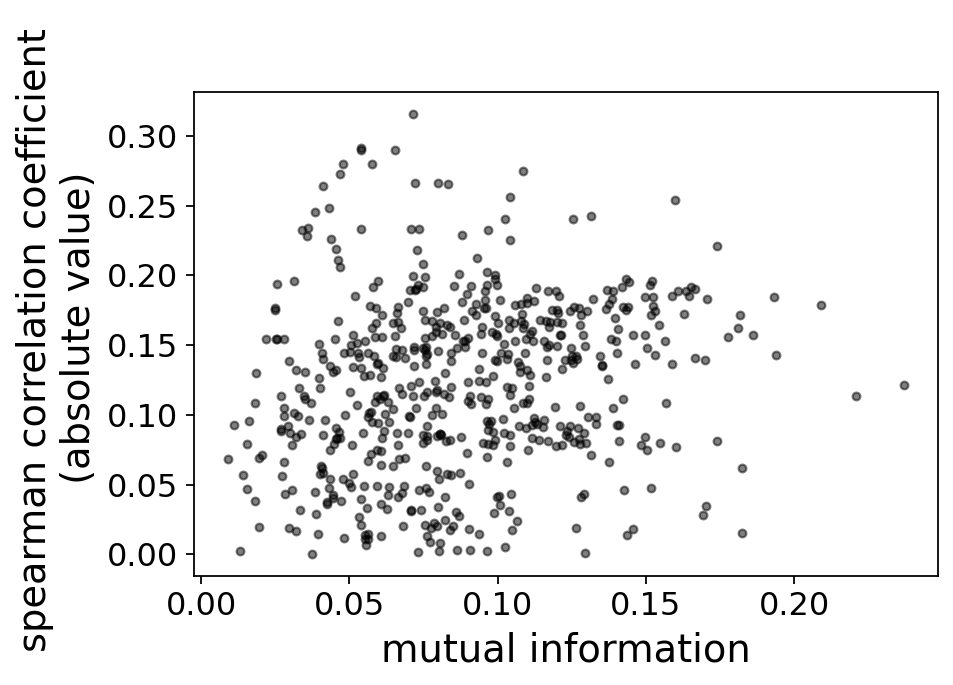

In [100]:
plt.scatter(MI_means, spearmans_abs, color='k', s=12, alpha=0.5)
plt.xlabel("mutual information")
plt.ylabel("spearman correlation coefficient \n (absolute value)")

Text(0, 0.5, 'spearman correlation coefficient')

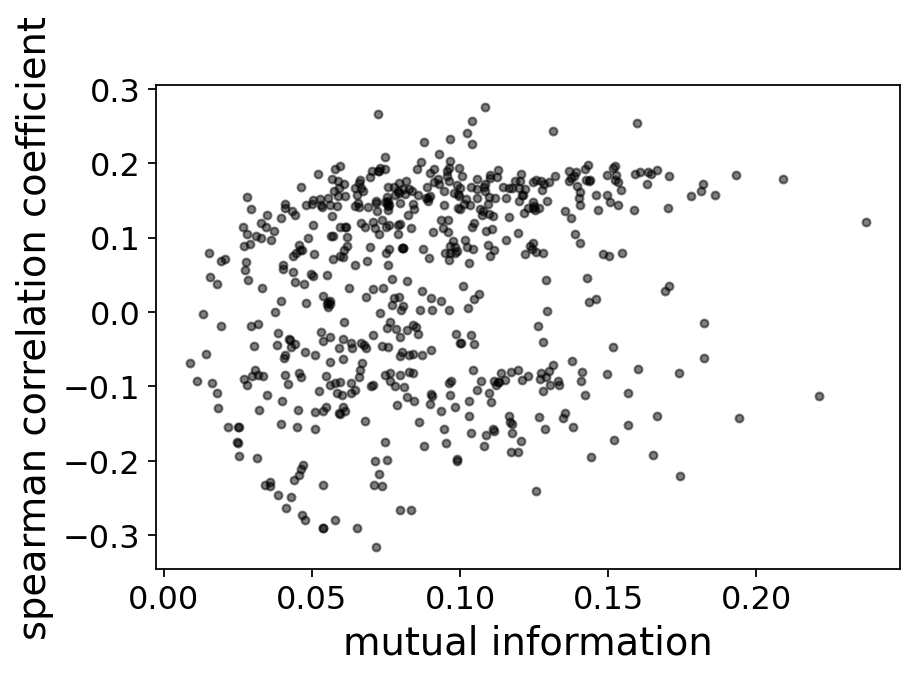

In [101]:
plt.scatter(MI_means, spearmans, color='k', s=12, alpha=0.5)
plt.xlabel("mutual information")
plt.ylabel("spearman correlation coefficient")

In [102]:
idx_MI_sorted = np.argsort(MI_means)[::-1]
idx_sp_sorted = np.argsort(spearmans_abs)[::-1]

Text(0, 0.5, 'MI / spearman')

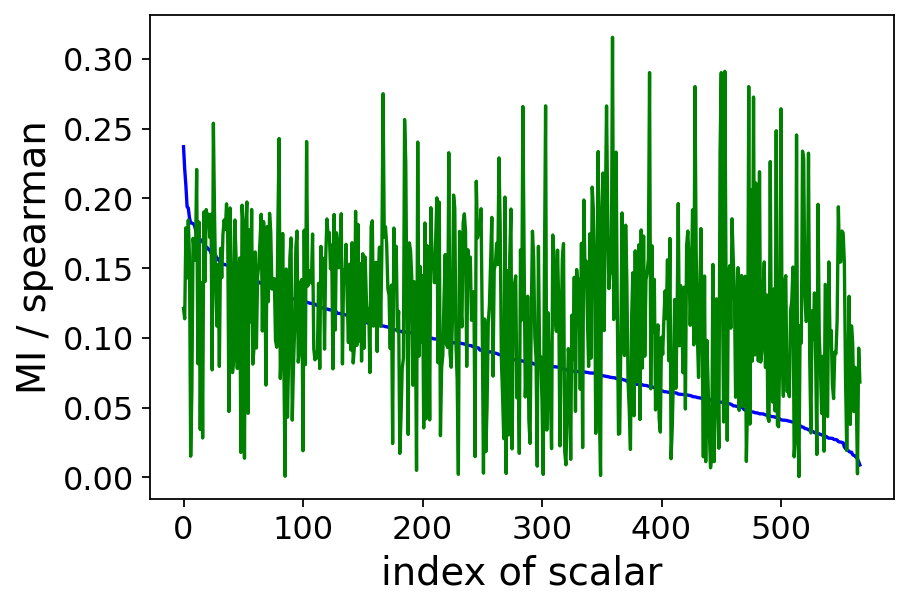

In [103]:
plt.plot(MI_means[idx_MI_sorted], color='blue')
plt.plot(spearmans_abs[idx_MI_sorted], color='green')

plt.xlabel("index of scalar")
plt.ylabel("MI / spearman")

Text(0, 0.5, 'MI / spearman')

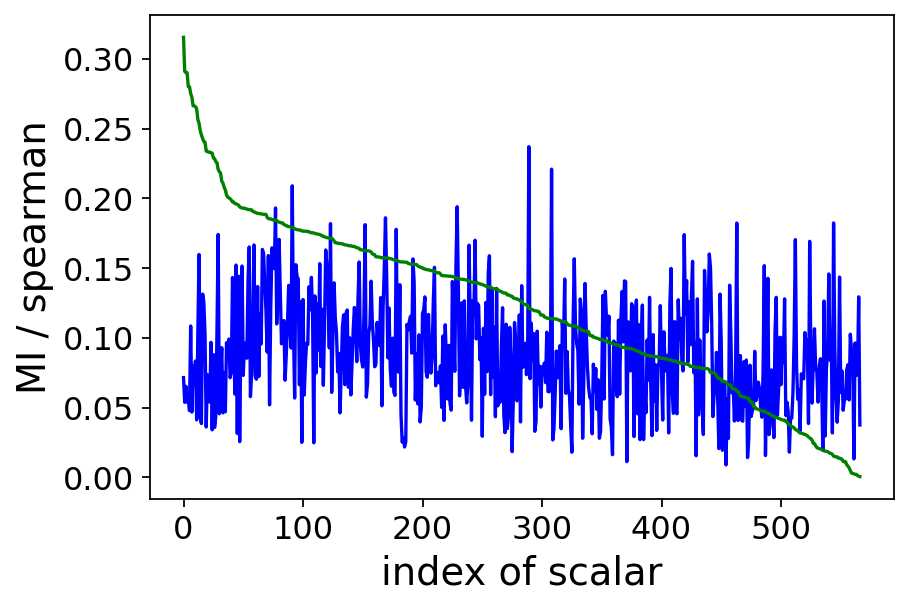

In [104]:
plt.plot(MI_means[idx_sp_sorted], color='blue')
plt.plot(spearmans_abs[idx_sp_sorted], color='green')

plt.xlabel("index of scalar")
plt.ylabel("MI / spearman")

Top MI:

In [106]:
for i in range(5):
    idx = idx_MI_sorted[i]
    print(display(Markdown(scalar_name(s_arr_train[0,idx], scalar_featurizer.geo_feature_arr))))
    print(MI_means[idx])

$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{vv}_2\right)$

None
0.23702480540517334


$\lambda_1\left(C^{xx}_0\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_2 + C^{vx}_2)\right)$

None
0.22091895332333764


$\lambda_2\left(C^{xx}_0\right) \, m_2$

None
0.20896196191643385


$\lambda_3\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right) \, \lambda_3\left(C^{vv}_2\right)$

None
0.1939371670619799


$m_2 \, m_2$

None
0.19305716952889299


Top SP:

In [107]:
for i in range(5):
    idx = idx_sp_sorted[i]
    print(display(Markdown(scalar_name(s_arr_train[0,idx], scalar_featurizer.geo_feature_arr))))
    print(MI_means[idx])

$\lambda_3\left(C^{vv}_0\right) \, m_1$

None
0.07148663867450583


$m_0 \, \lambda_3\left(C^{vv}_0\right)$

None
0.05375055122241688


$\lambda_3\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_0\right)$

None
0.06520101584735244


$\lambda_3\left(C^{vv}_0\right)$

None
0.053884134519419494


$m_0$

None
0.05765474356586557


# Investigate objects with agree / disagreeing spearman & MI

In [113]:
MI_lo = np.percentile(MI_means, 10)
MI_hi = np.percentile(MI_means, 90)
spearman_lo = np.percentile(spearmans_abs, 10)
spearman_hi = np.percentile(spearmans_abs, 90)

### Low MI, high Spearman

In [146]:
idx_feats = np.where((MI_means < MI_lo) & (spearmans_abs > spearman_hi))[0]
print(len(idx_feats))
for i in range(len(idx_feats)):
    print(display(Markdown(scalar_name(s_arr_train[0,idx_feats[i]], scalar_featurizer.geo_feature_arr))))

6


$m_0 \, \lambda_3\left(C^{xx}_0\right)$

None


$m_0 \, \lambda_2\left(C^{xx}_0\right)$

None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_0\right)$

None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_0\right)$

None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_0\right)$

None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_1\right)$

None


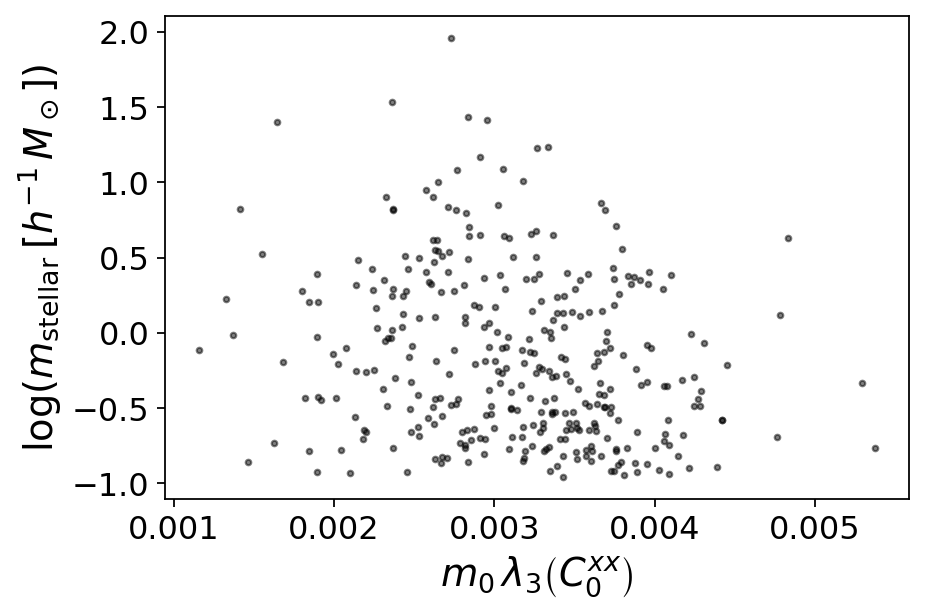

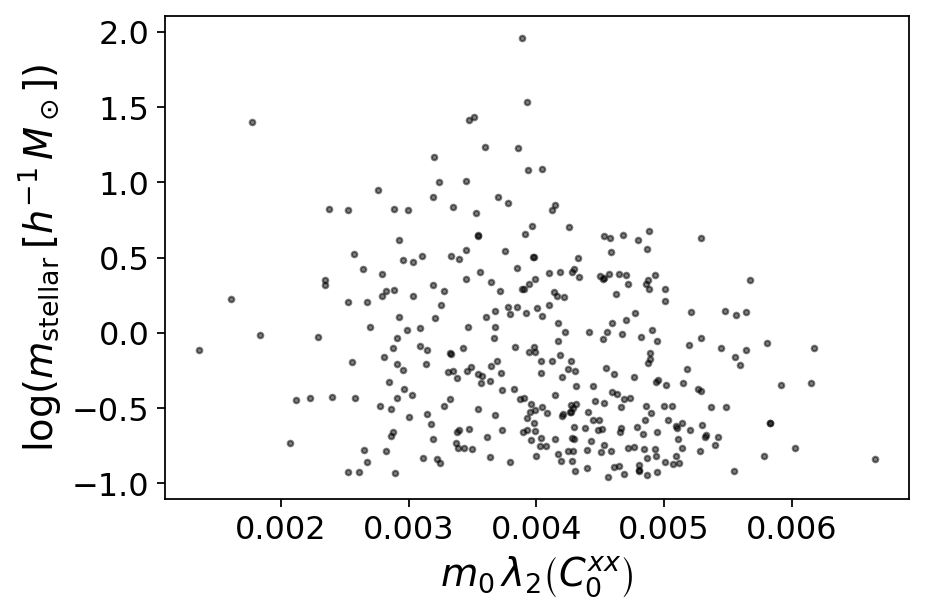

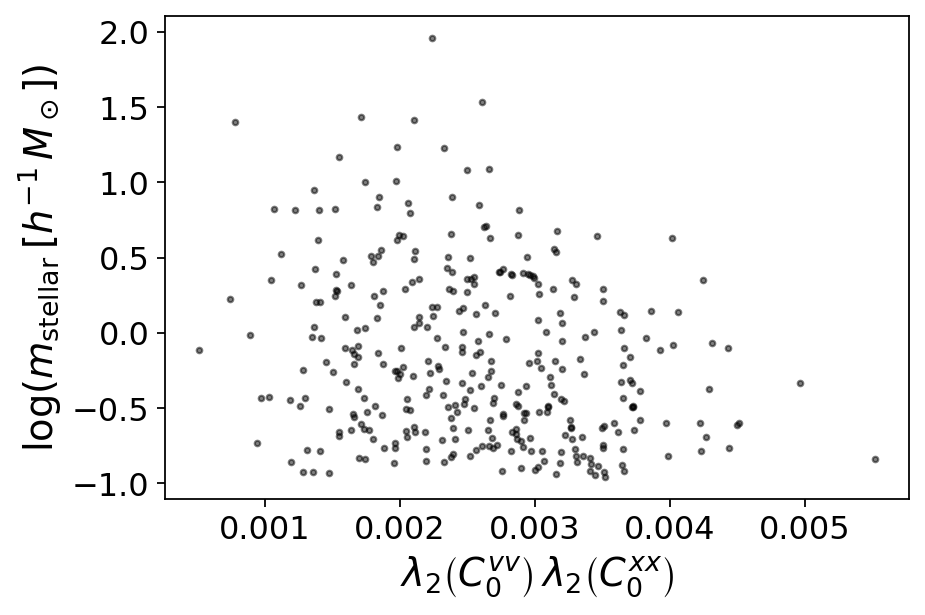

In [147]:
for i in range(3):
    idx_feat = idx_feats[i]
    plt.figure()
    plt.scatter(s_train[:,idx_feat], y_train, color='k', alpha=0.5, s=6)
    name = scalar_name(s_arr_train[0,idx_feat], scalar_featurizer.geo_feature_arr)
    plt.xlabel(name)
    plt.ylabel(utils.label_dict[y_label_name])

### High MI, low Spearman

In [144]:
idx_feats = np.where((MI_means > MI_hi) & (spearmans_abs < spearman_lo))[0]
print(len(idx_feats))
for i in range(len(idx_feats)):
    print(display(Markdown(scalar_name(s_arr_train[0,idx_feats[i]], scalar_featurizer.geo_feature_arr))))

5


$[v_1]_{j} \, [v_2]_{j}$

None


$m_0 \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

None


$\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

None


$[\frac{1}{2} (C^{xv}_0 + C^{vx}_0)]_{jk} \, [\frac{1}{2} (C^{xv}_2 + C^{vx}_2)]_{jk}$

None


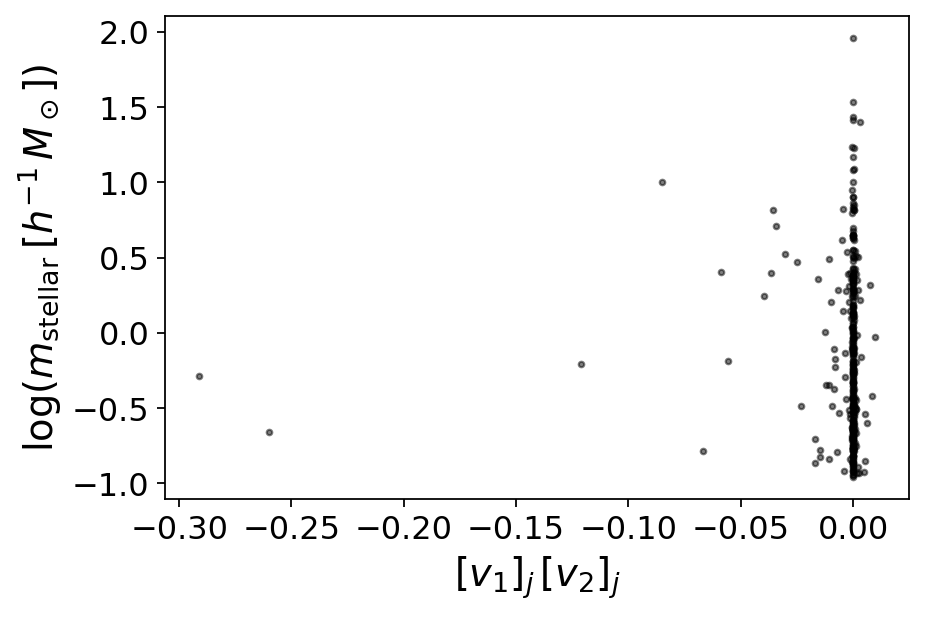

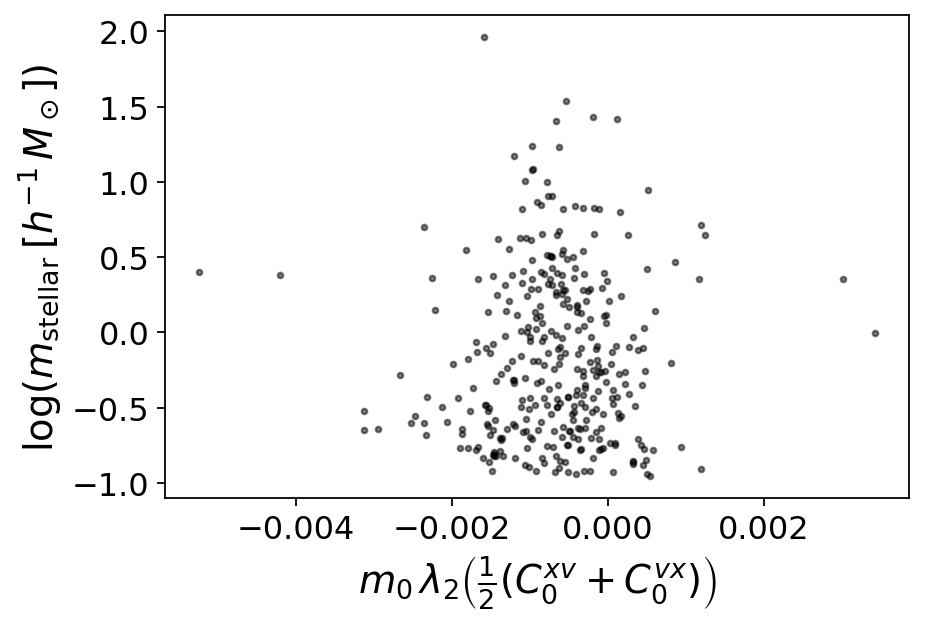

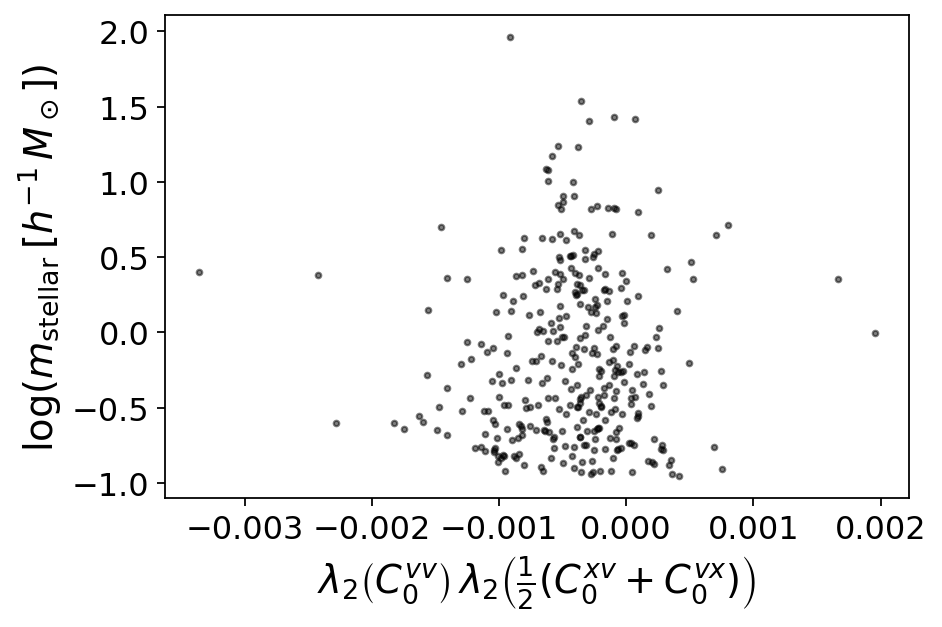

In [145]:
for i in range(3):
    idx_feat = idx_feats[i]
    plt.figure()
    plt.scatter(s_train[:,idx_feat], y_train, color='k', alpha=0.5, s=6)
    name = scalar_name(s_arr_train[0,idx_feat], scalar_featurizer.geo_feature_arr)
    plt.xlabel(name)
    plt.ylabel(utils.label_dict[y_label_name])

### Low MI, low Spearman

In [141]:
idx_feats = np.where((MI_means < MI_lo) & (spearmans_abs < spearman_lo))[0]
print(len(idx_feats))
for i in range(len(idx_feats)):
    print(display(Markdown(scalar_name(s_arr_train[0,idx_feats[i]], scalar_featurizer.geo_feature_arr))))

8


$\lambda_3\left(C^{xx}_1\right)$

None


$m_0 \, m_1$

None


$\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_1\right)$

None


$m_0 \, \lambda_2\left(C^{xx}_1\right)$

None


$\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_1\right)$

None


$[C^{xx}_0]_{jk} \, [C^{xx}_0]_{jk}$

None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_0\right)$

None


$\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_1\right)$

None


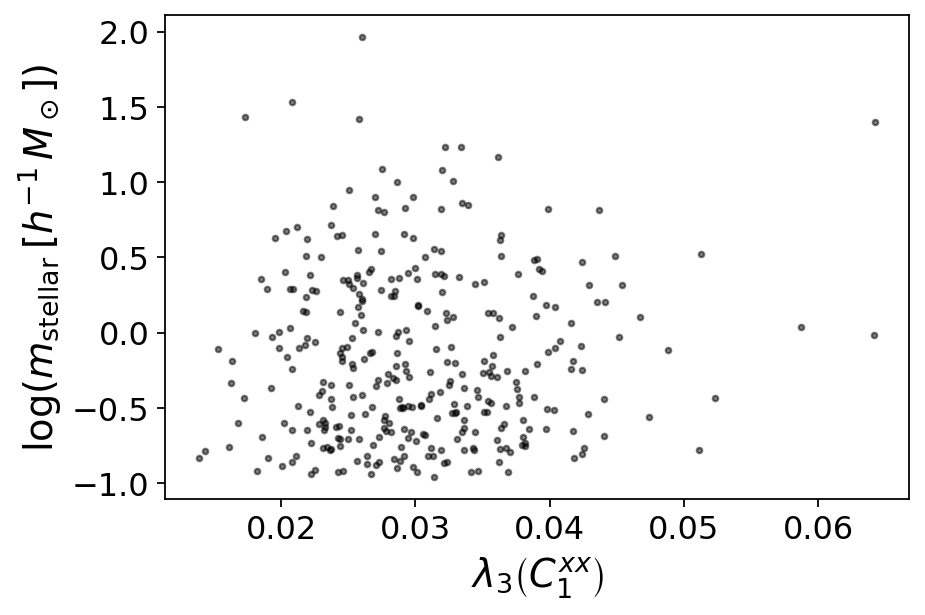

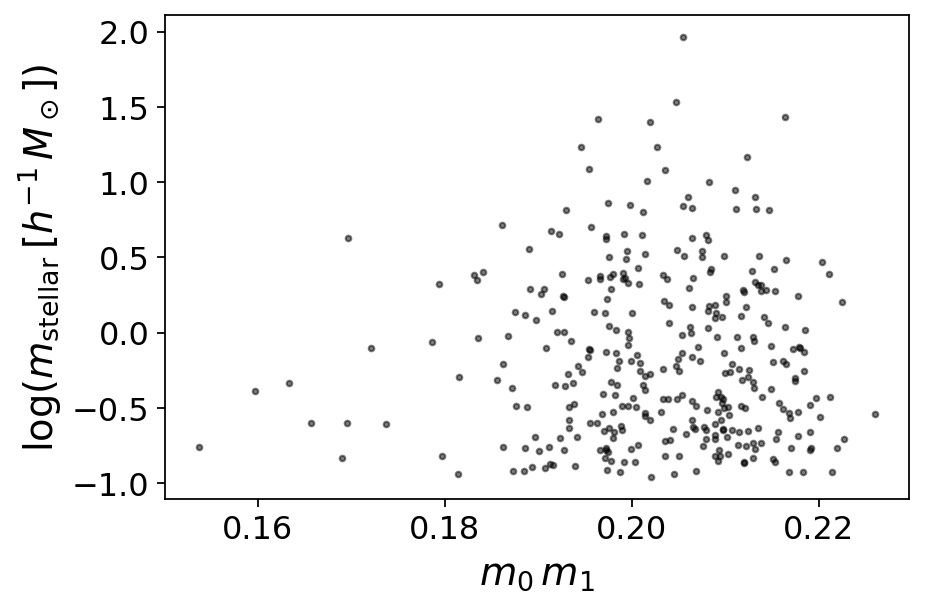

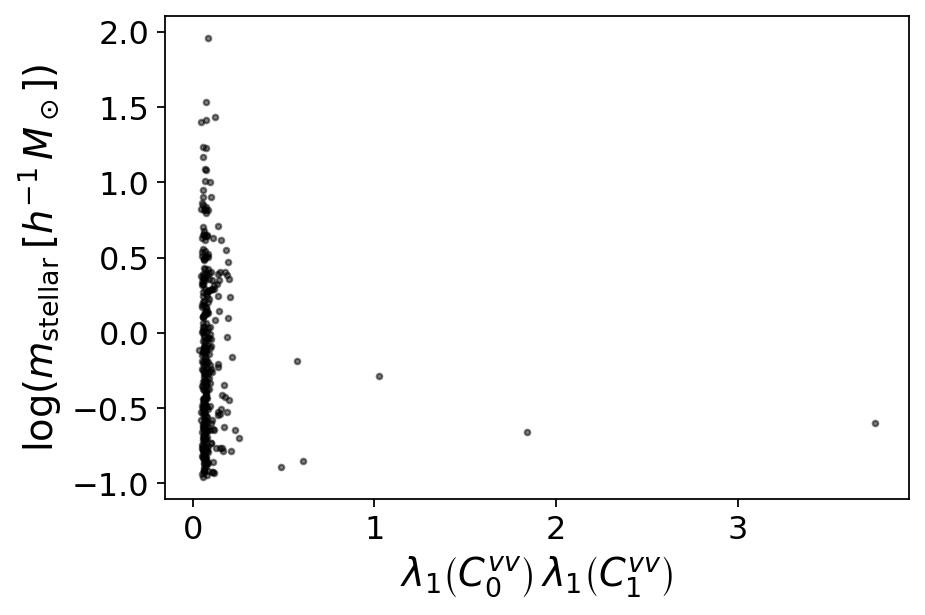

In [143]:
for i in range(3):
    idx_feat = idx_feats[i]
    plt.figure()
    plt.scatter(s_train[:,idx_feat], y_train, color='k', alpha=0.5, s=6)
    name = scalar_name(s_arr_train[0,idx_feat], scalar_featurizer.geo_feature_arr)
    plt.xlabel(name)
    plt.ylabel(utils.label_dict[y_label_name])

### High MI, high Spearman

In [136]:
idx_feats = np.where((MI_means > MI_hi) & (spearmans_abs > spearman_hi))[0]
print(len(idx_feats))
for i in range(len(idx_feats)):
    print(display(Markdown(scalar_name(s_arr_train[0,idx_feats[i]], scalar_featurizer.geo_feature_arr))))

7


$\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

None


$[x_0]_{j} \, [x_0]_{j}$

None


$\lambda_1\left(C^{xx}_0\right) \, m_2$

None


$\lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_3\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right)$

None


$\lambda_1\left(\frac{1}{2} (C^{xv}_0 + C^{vx}_0)\right) \, \lambda_2\left(\frac{1}{2} (C^{xv}_1 + C^{vx}_1)\right)$

None


$\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_2\right)$

None


$[C^{xx}_1]_{jk} \, [C^{xx}_2]_{jk}$

None


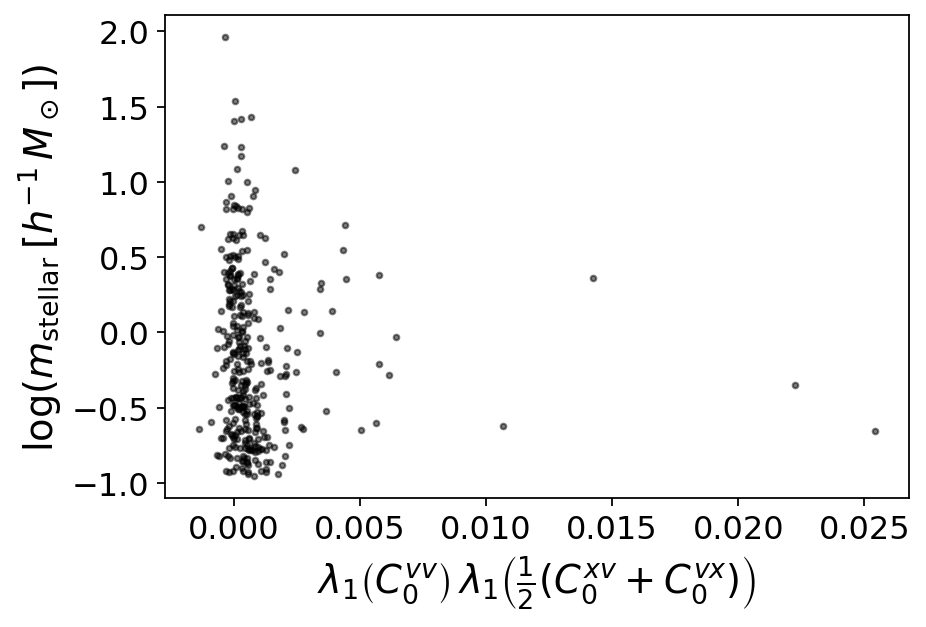

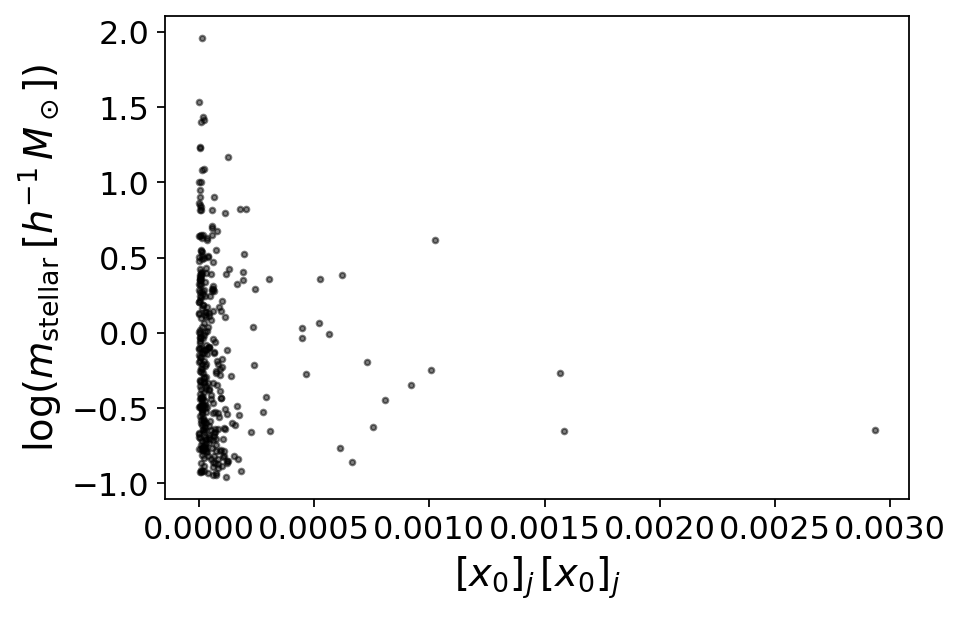

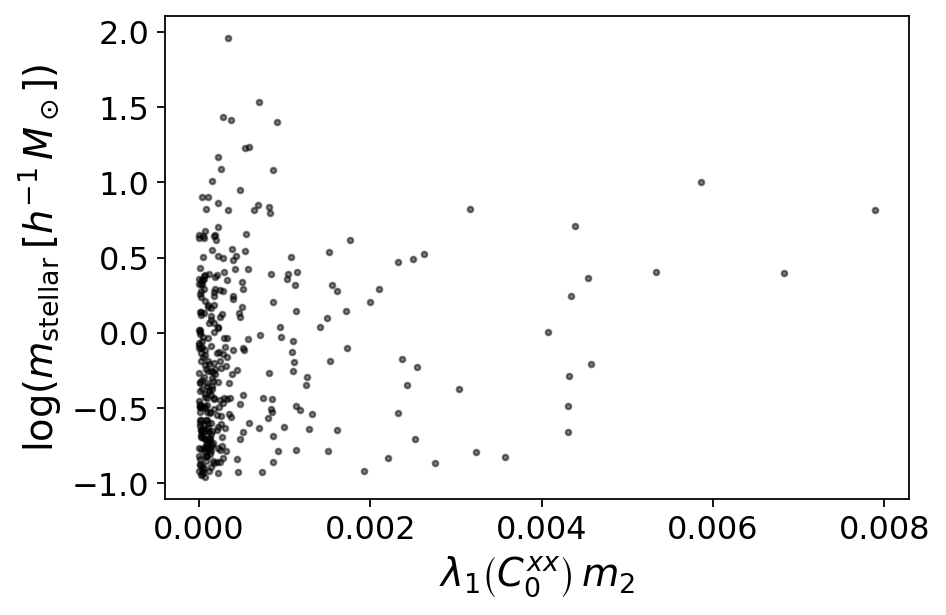

In [139]:
for i in range(3):
    idx_feat = idx_feats[i]
    plt.figure()
    plt.scatter(s_train[:,idx_feat], y_train, color='k', alpha=0.5, s=6)
    name = scalar_name(s_arr_train[0,idx_feat], scalar_featurizer.geo_feature_arr)
    plt.xlabel(name)
    plt.ylabel(utils.label_dict[y_label_name])